<a target="_blank" href="https://colab.research.google.com/github/UpstageAI/cookbook/blob/main/LangGraph-Self-RAG/langgraph_self_rag.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Upstage Self-RAG

Self-RAG is a strategy for RAG that incorperates [self-reflection / self-grading on retrieved documents and generations](https://blog.langchain.dev/agentic-rag-with-langgraph/). It leverages LLM to make decisions in the answer generation steps, hence improves quality of the final answer. 

See [Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection](https://arxiv.org/abs/2310.11511) paper for more detailed information.

In this example, we will implement some of these ideas. With [Upstage integrations](https://python.langchain.com/docs/integrations/providers/upstage/) and [LangGraph](https://python.langchain.com/docs/langgraph), you can achieve this with just a few additional lines of code. Particularly, it uses Upstage Solar Mini chat model, Embeddings model, Layout Analysis for document understanding and retrieval, and Groundedness Check for verifying the generative model's response. 

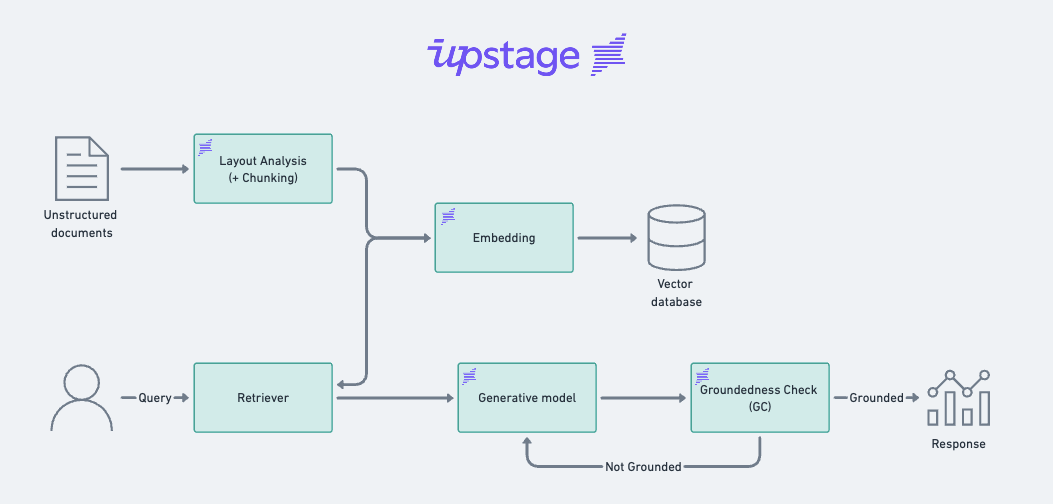

## Environment

In [1]:
!pip install -qU langchain-core langchain-upstage langchain-chroma langchain langgraph
!pip install -qU python-dotenv

### Environment variables

Set up environment variables 
* UPSTAGE_API_KEY

Optionally, set these environment variables to use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at the bottom)

```
LANGCHAIN_TRACING_V2=true
LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
LANGCHAIN_API_KEY=YOUR_KEY
```

In [8]:
from pprint import pprint
import os
import getpass
from typing import List
from langchain_core.documents import Document
from langchain_upstage import UpstageLayoutAnalysisLoader
from langchain_chroma import Chroma
from langchain_upstage import ChatUpstage, UpstageEmbeddings
from langchain_core.vectorstores import VectorStore

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

upstage_api_key = os.environ.get('UPSTAGE_API_KEY')
langchain_api_key = os.environ.get("LANGCHAIN_API_KEY")

In [2]:
#@title set API key
from pprint import pprint
import os
import getpass

import warnings
warnings.filterwarnings('ignore')

UPSTAGE_API_KEY = getpass.getpass('Enter your API Key')
_ = os.environ.setdefault("UPSTAGE_API_KEY", UPSTAGE_API_KEY)

LANGCHAIN_API_KEY = getpass.getpass('Enter your API Key')
_ = os.environ.setdefault("LANGCHAIN_API_KEY", LANGCHAIN_API_KEY)

In [9]:
#@title set API key
from pprint import pprint
import os

import warnings
warnings.filterwarnings('ignore')

from IPython import get_ipython

upstage_api_key_env_name = 'UPSTAGE_API_KEY'
langchain_api_key_env_name = 'LANGCHAIN_API_KEY'
def load_env():
    if 'google.colab' in str(get_ipython()):
        # Running in Google Colab
        from google.colab import userdata
        upstage_api_key = userdata.get(upstage_api_key_env_name)
        langchain_api_key = userdata.get(langchain_api_key_env_name)
        return os.environ.setdefault('UPSTAGE_API_KEY', upstage_api_key), os.environ.setdefault('LANGCHAIN_API_KEY', langchain_api_key)
    else:
        # Running in local Jupyter Notebook
        from dotenv import load_dotenv
        load_dotenv()
        return os.environ.get(upstage_api_key_env_name), os.environ.get(langchain_api_key_env_name)

UPSTAGE_API_KEY, LANGCHAIN_API_KEY = load_env()

## Retriever

### Prepare a file

This example will be using `docs/Upstage_Solar_DUS.pdf`. You can optionally add more files to the `docs` directory.

### Layout analysis

Prepare a function to use the Upstage [Layout Analysis](https://python.langchain.com/docs/integrations/document_loaders/upstage/) for document processing.

In [10]:
from typing import List
from langchain_core.documents import Document
from langchain_upstage import UpstageLayoutAnalysisLoader

def layout_analysis(filenames: str) -> List[Document]:
    layout_analysis_loader = UpstageLayoutAnalysisLoader(filenames, split="element")
    return layout_analysis_loader.load()

# Add more files if you'd like to.
filenames = [
    "pdfs/gstr2002-005c6.pdf",
]

docs = layout_analysis(filenames)
print(f'number of documents: {len(docs)}')
print(docs[0])

number of documents: 529
page_content='<h1 id='0' style='font-size:18px'>GSTR 2002/5 - Goods and services tax: when is a<br>'supply of a going concern' GST-free?</h1>' metadata={'page': 1, 'id': 0, 'bounding_box': '[{"x": 150, "y": 82}, {"x": 1085, "y": 82}, {"x": 1085, "y": 176}, {"x": 150, "y": 176}]', 'category': 'heading1'}


### Indexing

Let's index the file.

In [11]:
from langchain_chroma import Chroma
from langchain_upstage import ChatUpstage, UpstageEmbeddings
from langchain_core.vectorstores import VectorStore

db: VectorStore = Chroma(embedding_function=UpstageEmbeddings(model="solar-embedding-1-large"))
retriever = db.as_retriever()
db.add_documents(docs)

['d822750d-3e83-490e-83cc-7b4a043bee00',
 '9a2ee176-0a9d-424d-b163-558af61a2102',
 'e0c0e480-10d1-4cd2-89e4-e95ec0774e04',
 '7d379a07-359d-4e65-bee1-29f5044d33e9',
 '1520da69-16a1-4c8a-9d16-ee152ebd04aa',
 'dd779158-8652-43d9-99e1-b004029cf4db',
 '3ee942ef-3e79-44bf-bbe9-4e88bbd65c71',
 'f40a382a-98c9-44eb-8052-07d527698c7a',
 'de326228-01d7-479c-a110-9ebfe33291ce',
 'ecb25c4c-313a-4f19-bc36-60c8ee7be7f4',
 'd807d5a3-c742-4f4a-af03-5162934d26df',
 '349a1091-968f-4458-b679-2f331d35e6b4',
 'd8641543-a2f7-4e6b-836f-3ecd0d28dc1c',
 'd51cf10b-1b9d-42c9-a576-fcf79318ef07',
 '7fe98d0e-2992-4e8c-9655-a6dfbd6a6ab2',
 '620e40ee-060c-49ac-8666-aae675c8d0ca',
 '95c83e61-f543-49ce-b7a0-9fc43aba63f9',
 '0761eda0-c9fb-4c37-979c-62b51090ad34',
 '0e198a39-b638-4d50-b29f-895ec8c91376',
 '11c5c4f5-f906-46bf-a130-0c02a7613cc8',
 '87840509-7cb4-43fb-806d-d969973b440b',
 '342d142a-7f35-498a-9cb9-2a452db88a75',
 '6ee14455-0a72-4e05-8384-a6e3cc710859',
 '397ecd5e-cf74-4280-8aa0-b88c660981af',
 '7a330672-bafe-

## Graph State
Let's first define the LangGraph state.

In [12]:
from typing import TypedDict

class RagState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        context: retrieved context
        question: question asked by the user
        answer: generated answer to the question
        groundedness: groundedness of the assistant's response
    """
    context: str
    question: str
    answer: str
    groundedness: str

## RAG

Let's prepare RAG pipeline. It uses the Upstage [Solar chat model](https://python.langchain.com/docs/integrations/chat/upstage/).

In [13]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate


template = '''Answer the question based only on the given context.
{context}

Question: {question}
'''

prompt = ChatPromptTemplate.from_template(template)
model = ChatUpstage()

# Solar model answer generation, given the context and question
model_chain = prompt | model | StrOutputParser()

def format_documents(docs: List[Document]) -> str:
    return "\n".join([doc.page_content for doc in docs])
    
def retrieve(state: RagState) -> RagState:
    docs = retriever.invoke(state['question'])
    context = format_documents(docs)
    return RagState(context=context)

def model_answer(state: RagState) -> RagState:
    response = model_chain.invoke(state)
    return RagState(answer=response)

Now, let's prepare a logic for using Upstage [Groundedness Check](https://python.langchain.com/docs/integrations/tools/upstage_groundedness_check/).

In [14]:
from langchain_upstage import GroundednessCheck

gc = GroundednessCheck()

def groundedness_check(state: RagState) -> RagState:
    response = gc.run({"context": state['context'], "answer": state['answer']})
    return RagState(groundedness=response)

def groundedness_condition(state: RagState) -> RagState:
    return state['groundedness']

/home/nerdcat/miniconda3/envs/Epson-Challenge/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `GroundednessCheck` was deprecated in LangChain 0.1.3 and will be removed in 0.3.0. An updated version of the class exists in the langchain-upstage package and should be used instead. To use it run `pip install -U langchain-upstage` and import as `from langchain_upstage import UpstageGroundednessCheck`.
  warn_deprecated(


## Build Graph

Finally, let's put everything together and build the graph! The graph looks like the following.

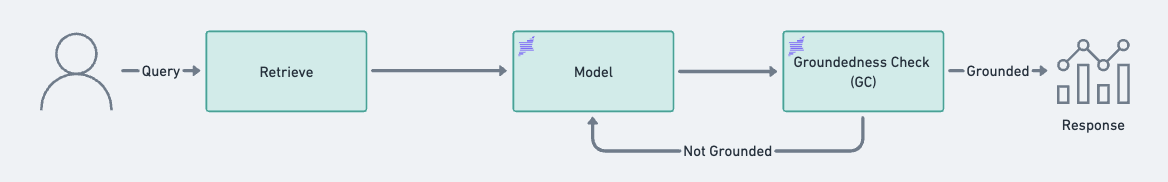

In [15]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(RagState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("model", model_answer)
workflow.add_node("groundedness_check", groundedness_check)

workflow.add_edge("retrieve", "model")
workflow.add_edge("model", "groundedness_check")
workflow.add_conditional_edges("groundedness_check", groundedness_condition, {
    "grounded": END,
    "notGrounded": "model",
    "notSure": "model",
})
workflow.set_entry_point("retrieve")

app = workflow.compile()

## Running the graph

Let's now test the graph.

In [17]:
inputs = {"question": "Tell me about the GST"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':{value}")
    print("\n---\n")

Node 'retrieve':{'context': "<h1 id='67' style='font-size:14px'>Goods and Services Tax Ruling</h1>\n<p id='0' data-category='paragraph' style='font-size:14px'>Goods and Services Tax Ruling</p>\n<p id='0' data-category='paragraph' style='font-size:16px'>Goods and Services Tax Ruling</p>\n<p id='0' data-category='paragraph' style='font-size:16px'>Goods and Services Tax Ruling</p>"}

---

Node 'model':{'answer': 'The given context does not provide any information about the Goods and Services Tax (GST).'}

---

Node 'groundedness_check':{'groundedness': 'notGrounded'}

---

Node 'model':{'answer': 'The context provided is a series of headings and paragraphs related to "Goods and Services Tax Ruling." However, it does not provide any specific information about the Goods and Services Tax (GST) itself. To answer questions about the GST, additional information or context would be required.'}

---

Node 'groundedness_check':{'groundedness': 'grounded'}

---



LangSmith Traces - 

* https://smith.langchain.com/public/5ce3f275-b93b-48d1-a718-88139ae2e00b/r